In [1]:
# import zipfile

# def unzip_file(zip_file_path, extract_to_path):
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_path)

# # Example usage
# zip_file_path = './taiwanesebankruptcyprediction.zip'
# extract_to_path = './'

# unzip_file(zip_file_path, extract_to_path)


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("./data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

<AxesSubplot:>

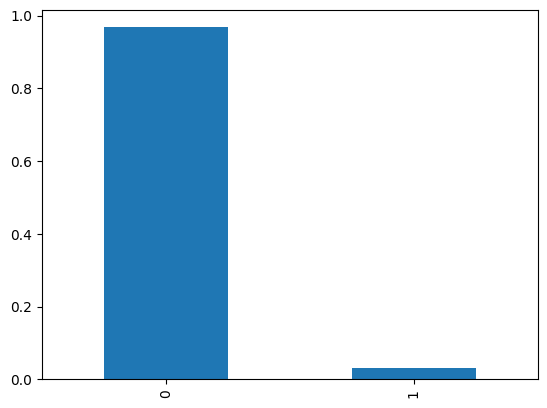

In [4]:
df["Bankrupt?"].value_counts(normalize=True).plot(kind='bar')

In [5]:
df["Bankruptdesc"] = df["Bankrupt?"].map({
    0 : "Not Bankrupt",
    1 : "Bankrupt"
})

<AxesSubplot:>

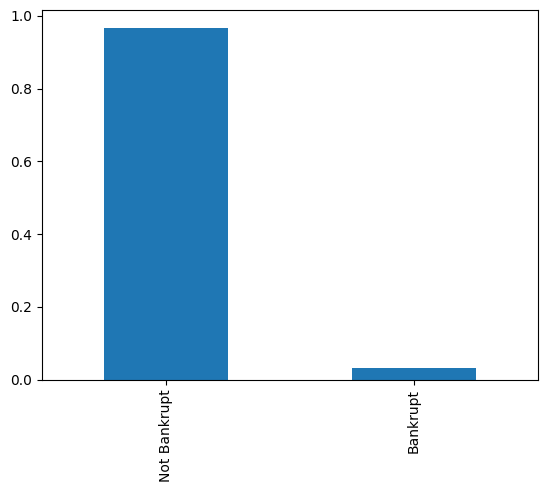

In [6]:
df["Bankruptdesc"].value_counts(normalize=True).plot(kind='bar')

### Down sampling

In [7]:
from sklearn.utils import resample

# Example: Under-sampling the majority class
minority_class = df[df['Bankrupt?'] == 1]
majority_class = df[df['Bankrupt?'] == 0]

majority_class_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

balanced_df = pd.concat([majority_class_downsampled, minority_class])


In [8]:
balanced_df.drop("Bankruptdesc", axis=1, inplace=True)

In [9]:
balanced_df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
2236,0,0.471945,0.540667,0.523636,0.607518,0.607518,0.999034,0.797471,0.809381,0.303531,...,0.801098,0.002294,0.623034,0.607520,0.840529,0.281733,0.026791,0.565159,1,0.023960
5538,0,0.507093,0.554187,0.558702,0.611972,0.611986,0.999132,0.797542,0.809430,0.303451,...,0.808595,0.002987,0.625407,0.611967,0.840884,0.277676,0.026885,0.565571,1,0.042552
4593,0,0.503924,0.550425,0.556936,0.605788,0.605788,0.999048,0.797459,0.809370,0.303481,...,0.806939,0.001287,0.624203,0.605785,0.840704,0.276773,0.026811,0.565249,1,0.056514
6315,0,0.451275,0.498528,0.503346,0.598438,0.598438,0.998972,0.797280,0.809214,0.303326,...,0.771691,0.008026,0.623244,0.598436,0.837267,0.284545,0.026559,0.563737,1,0.020046
4205,0,0.533418,0.613607,0.596445,0.613939,0.612743,0.999142,0.797527,0.809452,0.303401,...,0.837382,0.000646,0.623888,0.613937,0.843529,0.280201,0.026804,0.565218,1,0.027769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,1,0.418515,0.433984,0.461427,0.612750,0.612750,0.998864,0.796902,0.808857,0.302892,...,0.725750,0.000487,0.623730,0.612747,0.828067,0.292648,0.026666,0.564481,1,0.015620
6640,1,0.196802,0.211023,0.221425,0.598056,0.598056,0.998933,0.796144,0.808149,0.301423,...,0.519388,0.017588,0.623465,0.598051,0.856906,0.259280,0.026769,0.565052,1,0.003946
6641,1,0.337640,0.254307,0.378446,0.590842,0.590842,0.998869,0.796943,0.808897,0.302953,...,0.557733,0.000847,0.623302,0.590838,0.726888,0.336515,0.026777,0.565092,1,0.011797
6642,1,0.340028,0.344636,0.380213,0.581466,0.581466,0.998372,0.796292,0.808283,0.302857,...,0.641804,0.000376,0.623497,0.581461,0.765967,0.337315,0.026722,0.564807,1,0.011777


In [10]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features from target
X = balanced_df.iloc[:,1:]
y = balanced_df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
# Standardise the whole dataset
std_scaler = StandardScaler().fit(X_train)

def preprocessor(X):
    D = np.copy(X)
    D = std_scaler.transform(D)
    return D

In [11]:
preprocess_transformer = FunctionTransformer(preprocessor)
preprocess_transformer

FunctionTransformer(func=<function preprocessor at 0x00000220B49CAE58>)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

p1 = Pipeline([('scaler', preprocess_transformer),
              ('Logistic Regression', LogisticRegression())])
p1

Pipeline(steps=[('scaler',
                 FunctionTransformer(func=<function preprocessor at 0x00000220B49CAE58>)),
                ('Logistic Regression', LogisticRegression())])

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score

def fit_and_print(p, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    # Fit the transformer
    p.fit(X_train, y_train)
    # Predict the train and test outputs
    test_prediction =p.predict(X_test)
    
    # Print the errors
    print("Accuracy Score:   "+str(accuracy_score(test_prediction, y_test)*100))
    print("Precision Score:  "+str(precision_score(test_prediction, y_test)*100))
    print("Recall Score:     "+str(recall_score(test_prediction, y_test)*100))
    print("roc_auc_score:    "+str(accuracy_score(test_prediction, y_test)*100))
    print("\nConfusion Matrix:\n", confusion_matrix(test_prediction, y_test))

In [14]:
fit_and_print(p1)

Accuracy Score:   78.18181818181819
Precision Score:  80.76923076923077
Recall Score:     75.0
roc_auc_score:    78.18181818181819

Confusion Matrix:
 [[44 10]
 [14 42]]


In [17]:
X_test.shape

(110, 95)